# Analysis pipeline

## Preliminaries

In [679]:
import os
import datetime
import json
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import toolz

In [680]:
if 'get_ipython' in globals():
    get_ipython().run_line_magic('matplotlib', 'inline')
    from IPython.display import Image, HTML
else:
    HTML = lambda *a, **kw: None

In [681]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util
#reload(analysis_util), reload(util), reload(notebook_util), reload(automated_analyses)
from textrec.notebook_util import images, id2img, id2url, show_images

In [682]:
os.chdir(paths.top_level)

In [683]:
# HTML(show_images([images_by_split['val'][0]['cocoid']]))

## Load results of writing experiment

Prerequisites: Run `textrec.logs_to_csv {batch_name}` and `textrec.gruntwork {batch_name}`.

In [684]:
batch = os.environ.get('BATCH', 'gc1')
experiment_level_data = pd.read_csv(paths.analyzed / f'experiment_{batch}.csv')
block_level_data = pd.read_csv(paths.analyzed / f'block_{batch}.csv')
trial_level_data = pd.read_csv(paths.analyzed / f'trial_withmanual_{batch}.csv')
#trial_level_data = pd.read_csv(paths.analyzed / f'trial_{batch}.csv')
helpful_ranks_by_condition = pd.read_csv(paths.analyzed / f'helpful_ranks_by_condition_{batch}.csv').set_index('index')

In [685]:
def savefig(fn):
    plt.savefig(str(paths.figures / f'{batch}_{fn}.pdf'), metadata={'creationDate': None})

In [686]:
set(experiment_level_data.gender)

{'female', 'female ', 'male'}

In [687]:
data = dict(
    num_participants=len(set(trial_level_data.participant)),
    non_male=(experiment_level_data.gender != 'male').sum().item(),
    num_trials_per=trial_level_data.groupby('participant').size().mean().item(),
    n_trials=len(trial_level_data))

In [688]:
data['helpful_most_votes'] = helpful_ranks_by_condition.loc[:,[col for col in helpful_ranks_by_condition.columns if 'most' in col]].sum(axis=1).to_dict()
data['helpful_most_votes']

{'always': 70, 'gated': 24, 'norecs': 2}

In [689]:
data['helpful_least_votes'] = helpful_ranks_by_condition.loc[:,[col for col in helpful_ranks_by_condition.columns if 'least' in col]].sum(axis=1).to_dict()

In [690]:
HTML("Each of {num_participants} participants ({non_male} non-male) completed {num_trials_per} trials per experiment, for a total of {n_trials} trials.".format_map(data))

In [691]:
HTML("Participants spent {total_time_mean:.1f} +- {total_time_std:.1f} minutes total.".format(
    total_time_mean=experiment_level_data.total_time.mean(),
    total_time_std=experiment_level_data.total_time.std()))

In [692]:
experiment_level_data.columns

Index(['participant', 'age', 'english_proficiency', 'gender',
       'helpfulRank-accurate-least-condition',
       'helpfulRank-accurate-least-idx', 'helpfulRank-accurate-most-condition',
       'helpfulRank-accurate-most-idx', 'helpfulRank-quick-least-condition',
       'helpfulRank-quick-least-idx', 'helpfulRank-quick-most-condition',
       'helpfulRank-quick-most-idx', 'helpfulRank-specific-least-condition',
       'helpfulRank-specific-least-idx', 'helpfulRank-specific-most-condition',
       'helpfulRank-specific-most-idx', 'other', 'techDiff', 'total_time',
       'use_predictive', 'verbalized_during', 'condition_order',
       'num_trials_where_recs_used', 'rec_use_group', 'NFC', 'NFC_boxcox',
       'Extraversion', 'Extraversion_boxcox', 'Openness', 'Openness_boxcox',
       'Trust', 'Trust_boxcox'],
      dtype='object')

In [693]:
data['used_predictive'] = {k.replace(' ', '_'): v for k, v in 
                                     experiment_level_data.use_predictive.value_counts().to_dict().items()}
data['verbalized_during'] = experiment_level_data.verbalized_during.value_counts().to_dict()
data['rec_use_group'] = experiment_level_data.rec_use_group.value_counts().to_dict()
print('used_predictive', data['used_predictive'])

used_predictive {'Often': 14, 'Rarely': 11, 'Very_Rarely': 6, 'Almost_Always': 1}


In [694]:
HTML("""
Most participants reported (before beginning the study) that they used predictive typing on their phones:
""" + experiment_level_data.use_predictive.value_counts().to_frame("Used predictive typing?").to_html())

,Used predictive typing?
Often,14
Rarely,11
Very Rarely,6
Almost Always,1


In [695]:
HTML("""
Several participants answered Yes to "While you were writing, did you speak or whisper what you were writing?":
""" + experiment_level_data.verbalized_during.value_counts().to_frame("Verbalized?").to_html())

,Verbalized?
No,29
Yes,3


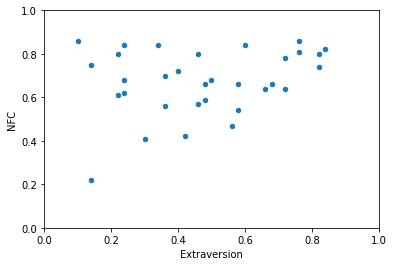

In [696]:
experiment_level_data.plot.scatter(x='Extraversion', y='NFC');
plt.xlim([0, 1])
plt.ylim([0, 1]);
savefig('trait_distribution')
HTML("""
We collected 10 items each for NFC and Extraversion.
We obtained a wider range of Extraversion than NFC.
(Min and max scales normalized to 0 and 1 respectively.)""")

In [697]:
def latexify_conds(txt):
    for cond in 'norecs specific general'.split():
        txt = txt.replace(cond, f'\\S{cond}')
    return txt

In [698]:
covc = experiment_level_data.condition_order.value_counts()
covc.name = 'Num participants'
covc = covc.to_latex()
covc = covc.replace(',', ', ')
covc = latexify_conds(covc)
print(covc)
data['condition_order_table'] = covc

\begin{tabular}{lr}
\toprule
{} &  Num participants \\
\midrule
\Snorecs, gated, always &                 6 \\
always, gated, \Snorecs &                 6 \\
gated, \Snorecs, always &                 5 \\
always, \Snorecs, gated &                 5 \\
\Snorecs, always, gated &                 5 \\
gated, always, \Snorecs &                 5 \\
\bottomrule
\end{tabular}



In [699]:
HTML("""When running this experiment, the experiment software was configured to randomize the order
of conditions seen by each subject, not to attempt to counterbalance order.
This was fixed in subsequent experiments."""
     + experiment_level_data.condition_order.value_counts().to_frame().to_html())

,condition_order
"norecs,gated,always",6
"always,gated,norecs",6
"gated,norecs,always",5
"always,norecs,gated",5
"norecs,always,gated",5
"gated,always,norecs",5


In [700]:
def summarize_means(df, by, outcome):
    means = df.groupby(by)[outcome].mean()
    data[f'{outcome}_means'] = means.to_dict()
    return ', '.join(f'{name}={group_mean:.2f}' for name, group_mean in means.iteritems())

In [701]:
def analyze_outcome(df, by, outcome):
    plt.close('all')
    sns.barplot(x=by, y=outcome, data=df, capsize=.2)
    savefig(outcome)
    return summarize_means(df, by, outcome)

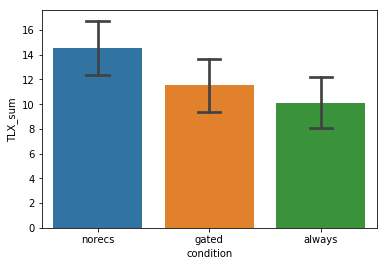

In [702]:
sns.barplot(x='condition', y='TLX_sum', data=block_level_data, capsize=.2)
HTML("The average cognitive load was higher in the no-recommendations condition ({})".format(
    analyze_outcome(block_level_data, 'condition', 'TLX_sum')))

'always=10.06, gated=11.53, norecs=14.56'

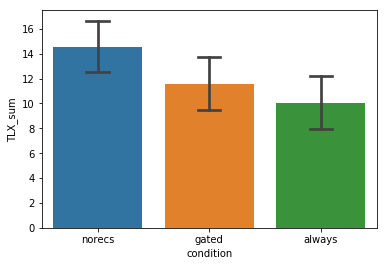

In [703]:
analyze_outcome(block_level_data, 'condition', 'TLX_sum')

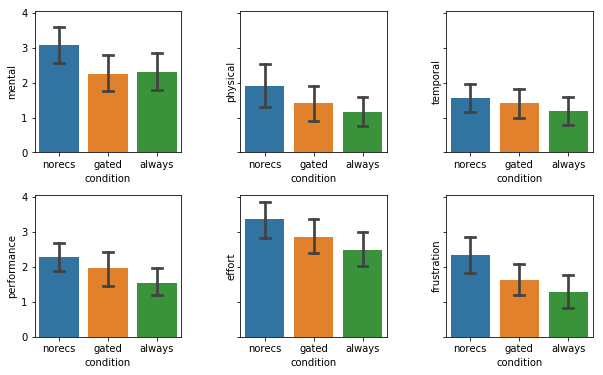

In [704]:
plt.close('all')
tlxen = 'mental physical temporal performance effort frustration'.split()
fig, axs = plt.subplots(2, 3, figsize=(10,6), sharey=True)
plt.subplots_adjust(wspace=.4, hspace=.3)
for i, facet in enumerate(tlxen):
    ax = axs.ravel()[i]
    sns.barplot(x='condition', y=facet, data=block_level_data, capsize=.2, ax=ax)
savefig('tlx_parts')

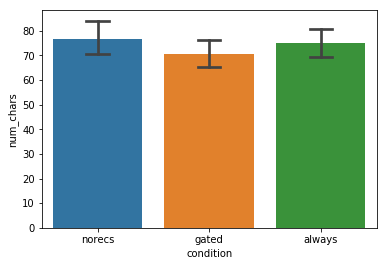

In [705]:
HTML("There was no difference in text length between conditions ({}).".format(
    analyze_outcome(trial_level_data, 'condition', 'num_chars')))

'always=14.95, gated=13.95, norecs=15.09'

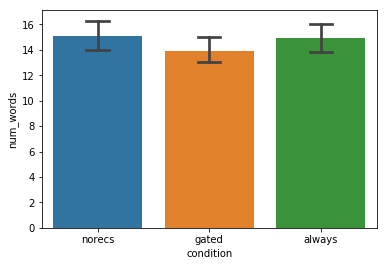

In [706]:
analyze_outcome(trial_level_data, 'condition', 'num_words')

'always=0.12, gated=0.14, norecs=0.17'

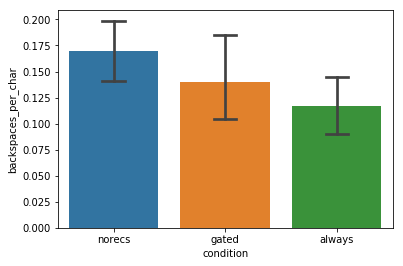

In [707]:
analyze_outcome(trial_level_data, 'condition', 'backspaces_per_char')

'always=0.00, gated=0.00, norecs=0.00'

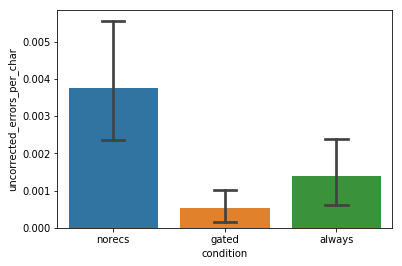

In [708]:
analyze_outcome(trial_level_data, 'condition', 'uncorrected_errors_per_char')

'always=9.45, gated=9.30, norecs=13.15'

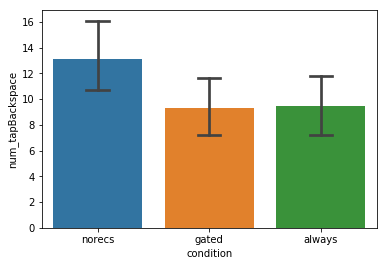

In [709]:
analyze_outcome(trial_level_data, 'condition', 'num_tapBackspace')

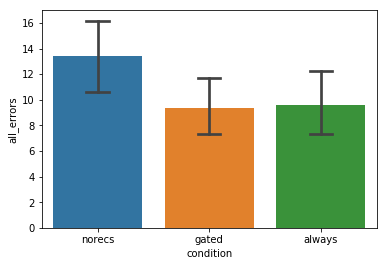

In [710]:
sns.barplot(x='condition', y='all_errors', data=trial_level_data, capsize=.2)
HTML("Participants made more errors (corrected + uncorrected) in the no-recommendations condition ({}).".format(
    summarize_means(trial_level_data, 'condition', 'all_errors')))

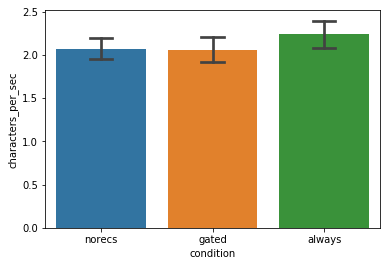

In [711]:
HTML("Participants were slightly faster in the recommendations conditions (characters per second: {}).".format(
    analyze_outcome(trial_level_data, 'condition', 'characters_per_sec')))

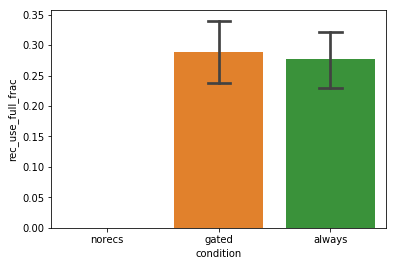

In [712]:
sns.barplot(x='condition', y='rec_use_full_frac', data=trial_level_data, capsize=.2)
HTML("Participants used available recommendations slightly more often when they were specific (use rate: {}).".format(
    summarize_means(trial_level_data, 'condition', 'rec_use_full_frac')))

'always=0.50, gated=0.56, norecs=0.34'

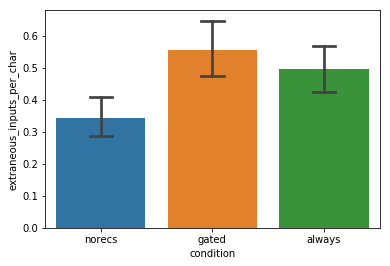

In [713]:
analyze_outcome(trial_level_data, 'condition', 'extraneous_inputs_per_char')

'always=3.21, gated=3.29, norecs=3.01'

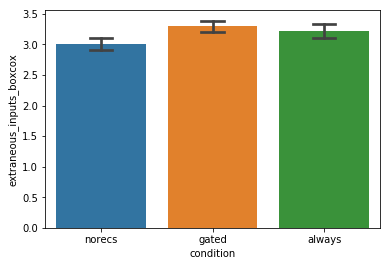

In [714]:
analyze_outcome(trial_level_data, 'condition', 'extraneous_inputs_boxcox')

'always=0.26, gated=0.24, norecs=nan'

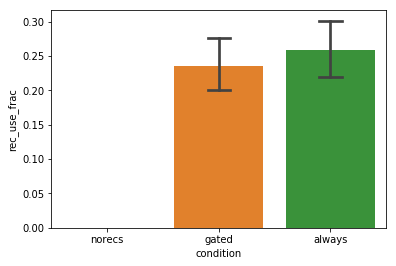

In [715]:
analyze_outcome(trial_level_data, 'condition', 'rec_use_frac')

'always=0.28, gated=0.29, norecs=nan'

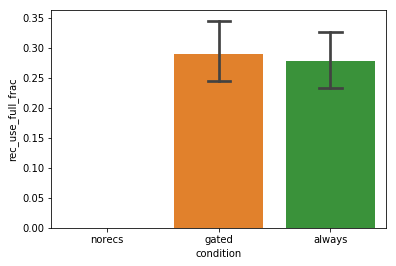

In [716]:
analyze_outcome(trial_level_data, 'condition', 'rec_use_full_frac')

'always=-3.20, gated=-3.38, norecs=-3.61'

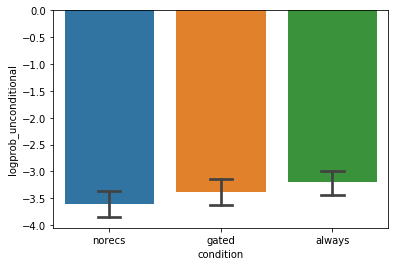

In [717]:
analyze_outcome(trial_level_data, 'condition', 'logprob_unconditional')

'always=-3.02, gated=-3.17, norecs=-3.40'

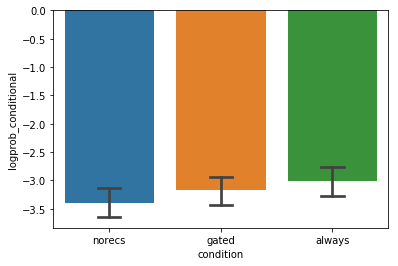

In [718]:
analyze_outcome(trial_level_data, 'condition', 'logprob_conditional')

'always=15.95, gated=19.27, norecs=22.97'

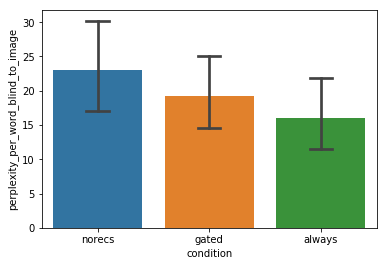

In [719]:
analyze_outcome(trial_level_data, 'condition', 'perplexity_per_word_blind_to_image')

0.7598678448287823

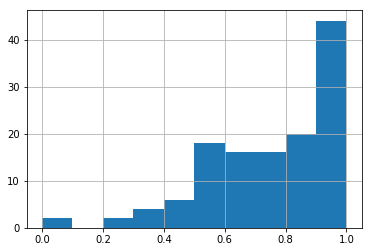

In [720]:
condition = 'gated'
trials = trial_level_data[trial_level_data.condition == condition]
useful_if_shown = (trials.orig_bow_recs_idealuse_cond / trials.orig_bow_recs_offered_cond)
useful_if_shown.hist()
useful_if_shown.mean()

0.612033357080716

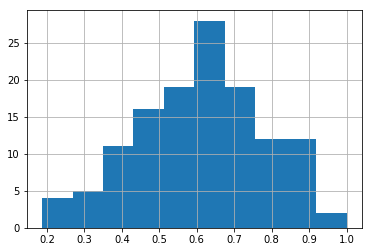

In [721]:
condition = 'always'
trials = trial_level_data[trial_level_data.condition == condition]
useful_if_shown = (trials.orig_bow_recs_idealuse_cond / trials.orig_bow_recs_offered_cond)
useful_if_shown.hist()
useful_if_shown.mean()

In [722]:
weird_ttts = trial_level_data[trial_level_data.orig_tapstotype_cond > trial_level_data.num_taps]
if len(weird_ttts) > 0:
    print("SOME WEIRD TapsToType")
    print(weird_ttts.loc[:,['participant', 'stimulus', 'text', 'condition', 'num_taps', 'orig_tapstotype_cond']])

In [723]:
print('\n\n'.join(x for x in experiment_level_data['techDiff'] if x is not None))

No

No

None

None

None

No

No

No

None

No

None

None

No.

No

None

No

None

No

no

No

None

No

No

None

Nope

No

No

No

None

No.

No

No


In [724]:
print('\n\n'.join(x for x in experiment_level_data['other'] if isinstance(x, str)))

None

None

None

None

None

It went well

Thanks!

Enjoyed it.I wish I didn't have to do it in portrait mode - I am very slow that way.

None

My screen keep getting big from hitting it over and over but that wasn't your fault

None

None

Design 2 and 3 seemed identical to me, so I just chose 2 for my answers because I can’t choose both 2 and 3. Also, the question directly above that asks if there’s any reason you shouldn’t use my data doesn’t actually have an answer listed. But, no, there’s no reason you shouldn’t use my data.

None

None

All is well

The question above doesn't give me buttons to respond to but I did take this study seriously and you can use my data.

Everything was fine, it went well.

None

None

None

None

None

The keys seemed so tiny in all three. It was hard to type. 

None

None

Great, enjoyed it!

None

None

I enjoyed the experience


In [725]:
trial_level_data.columns

Index(['participant', 'age', 'english_proficiency', 'gender',
       'helpfulRank-accurate-least-condition',
       'helpfulRank-accurate-least-idx', 'helpfulRank-accurate-most-condition',
       'helpfulRank-accurate-most-idx', 'helpfulRank-quick-least-condition',
       'helpfulRank-quick-least-idx',
       ...
       'corrected_tapstotype_gated', 'corrected_idealrecuse_gated',
       'corrected_bow_recs_offered_gated', 'corrected_bow_recs_idealuse_gated',
       'corrected_tapstotype_always', 'corrected_idealrecuse_always',
       'corrected_bow_recs_offered_always',
       'corrected_bow_recs_idealuse_always', 'corrected_tapstotype_cond',
       'corrected_efficiency'],
      dtype='object', length=138)

In [726]:
import yaml

In [727]:
data_fname = paths.analyzed / 'data.yaml'
if data_fname.exists():
    with open(data_fname, 'r') as f:
        yaml_data = yaml.safe_load(f)
else:
    yaml_data = {}

In [728]:
yaml_data[batch] = data

In [729]:
with open(data_fname, 'w') as f:
    yaml.safe_dump(yaml_data, f)

In [730]:
assert False

AssertionError: 

In [ ]:
import pickle
pickle.dump({batch: data}, open(paths.analyzed / 'data.pkl', 'wb'), -1)

In [ ]:
num_details = pd.read_csv(paths.data / 'num_details_spec1.csv').rename(columns={
    'image_id': 'stimulus',
    'text': 'corrected_text'
})

In [ ]:
with_num_details = pd.merge(
    trial_level_data,
    num_details,
    on=('stimulus', 'corrected_text'),
#     right_on=('image_id', 'text'),
    how='outer')

In [ ]:
with_num_details

In [ ]:
sns.barplot(x='condition', y='num_details', data=with_num_details, capsize=.2)

In [ ]:
with_num_details.num_details.describe()

In [ ]:
print('\n'.join(with_num_details.sort_values('num_details').text.iloc[-5:]))

In [ ]:
with_num_details.to_csv('with_num_details.csv')

Bonus the most specific captions for each image. Some participants wrote the most specific captions for several images, so they get mulitple bonuses.

In [ ]:
with_num_details.sort_values('num_details', ascending=False).drop_duplicates(['stimulus']).loc[:,['participant', 'corrected_text', 'num_details']].groupby('participant').size() * 0.50

In [ ]:
from textrec import onmt_model_2

In [ ]:
def get_recs_cap(cocoid, context, prefix=None):
    return onmt_model_2.get_recs('coco_cap', str(cocoid), context, prefix=prefix)

def get_recs_lm(cocoid, context, prefix=None):
    return onmt_model_2.get_recs('coco_lm', '.', context, prefix=prefix)

In [ ]:
get_recs_cap(71815, 'a'.split(), prefix='t')

In [ ]:
from functools import partial

In [ ]:
txt = "a tennis player swinging at a ball"
txt[:0].rsplit(' ', 1)

In [ ]:
txt.rindex(' ')

In [ ]:
def taps_to_type(rec_gen, txt):
    actions = []
    # Invariant: performing [actions] types txt[:idx]
    idx = 0
    while idx < len(txt):
        sofar = txt[:idx]
        if ' ' in sofar:
            last_space_idx = sofar.rindex(' ')
        else:
            last_space_idx = -1
        prefix = sofar[:last_space_idx + 1]
        cur_word = sofar[last_space_idx + 1:]
        cur_desired_word = txt[last_space_idx + 1:].split(' ', 1)[0]
#         if cur_desired_word[-1] in ',.;-':
#             cur_desired_word = cur_desired_word[:-1]
#         print(repr(prefix), repr(cur_word), repr(cur_desired_word))
        recs = rec_gen(onmt_model_2.tokenize(prefix), prefix=cur_word)
        words = [word for word, rec in recs]
        print(prefix, words)
        if cur_desired_word in words:
            actions.append(dict(type='rec', which=words.index(cur_desired_word), word=cur_desired_word))
            idx = last_space_idx + 1 + len(cur_desired_word) + 1
        else:
            actions.append(dict(type='key', key=txt[idx]))
            idx += 1
        print(actions[-1])
    return actions
taps_to_type(partial(get_recs_cap, 71815), "a young man wearing a red shirt and holding a white and red tennis racket")

In [ ]:
if False:
    writer = pd.ExcelWriter('specificity_details.xlsx')
    for stim, group in trial_level_data.groupby('stimulus'):
        group.loc[:,['corrected_text']].to_excel(writer, str(stim))
    writer.close()

In [ ]:
if False:
    for stim, txts in trial_level_data.groupby('stimulus').text:
        print()
        print(stim)
        print('\n'.join(txts))
        txts.to_csv(f'{stim}.csv', index=False)